In [38]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Image into TF Data Pipeline

In [41]:
current_folder = os.path.abspath('')
IMAGES_PATH = os.path.join(current_folder,'data','images')
print(IMAGES_PATH)

images = tf.data.Dataset.list_files(IMAGES_PATH + '/*.jpg', shuffle=False)

/Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images/*.jpg'

In [ ]:
images.as_numpy_iterator().next()

2023-07-30 17:48:16.887556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


b'/Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images/52f25046-2eb0-11ee-9794-166359f0a21b.jpg'

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

2023-07-30 17:48:28.797153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


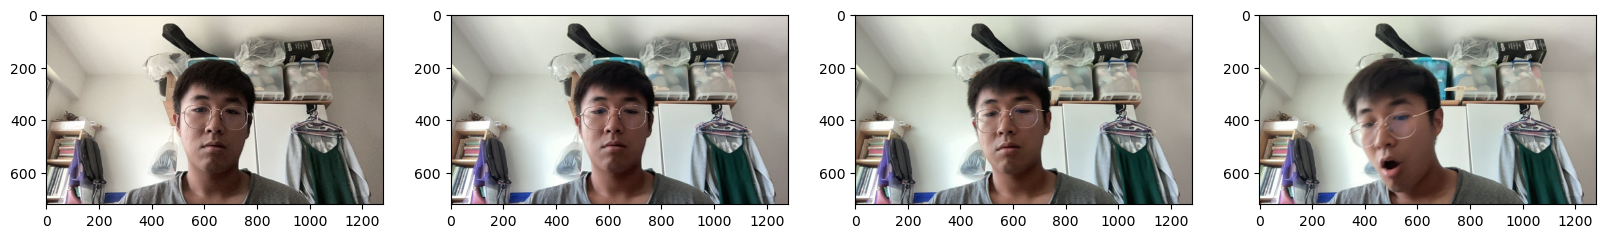

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unaugmented Data

In [ ]:
current_folder = os.path.abspath('')
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(current_folder,'data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(current_folder,'data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## Apply Image Augmentation on Images and Labels using Albumentations
This part sets up the Albumentation pipeline and tests it on 1 image.

In [42]:
import albumentations as alb
import cv2

In [43]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [44]:
img = cv2.imread(os.path.join('data','train', 'images','8d8023dc-2eb0-11ee-b1eb-166359f0a21b.jpg'))
img.shape

(720, 1280, 3)

In [45]:
with open(os.path.join('data', 'train', 'labels', '8d8023dc-2eb0-11ee-b1eb-166359f0a21b.json'), 'r') as f:
    label = json.load(f)
# label['shapes'][0]['points']

In [46]:
# Shows the bounding box coordinates

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
# coords

In [47]:
coords = list(np.divide(coords, [1280,720,1280,720]))
# coords

In [48]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [49]:
augmented['bboxes']

[(0.1867884322678841,
  0.2375038051750381,
  0.5794824961948248,
  0.7763165905631659)]

In [50]:
augmented['bboxes'][0][2:]

(0.5794824961948248, 0.7763165905631659)

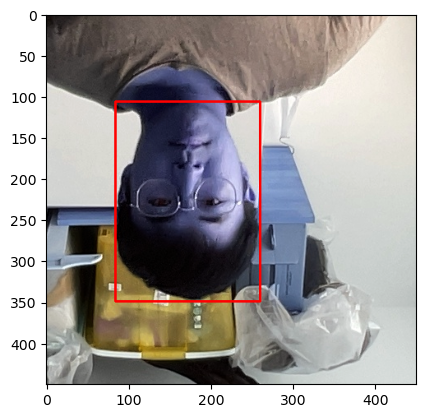

In [51]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## Using the Albumentation Pipeline to Augment the Data

In [53]:
current_folder = os.path.abspath('')

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join(current_folder, 'data', partition, 'images')):
        img = cv2.imread(os.path.join(current_folder, 'data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(current_folder, 'data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(current_folder, 'aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join(current_folder,  'aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.4111729452054795, 0.8339041095890412, 0.05158390410958903, 0.15468036529680368, 'face'].
x_max is less than or equal to x_min for bbox [0.5502996575342466, 0.24600456621004568, 0.23886986301369864, 0.7806316590563167, 'face'].
x_max is less than or equal to x_min for bbox [0.559931506849315, 0.4514840182648402, 0.26388652711285965, 0.9986111111111111, 'face'].
x_max is less than or equal to x_min for bbox [0.8542380136986301, 0.9271308980213091, 0.5074914383561644, 0.22127092846270932, 'face'].
y_max is less than or equal to y_min for bbox [0.4539811643835616, 0.6113013698630136, 0.734375, 0.05764840182648405, 'face'].
x_max is less than or equal to x_min for bbox [0.7354452054794521, 0.8091704718417049, 0.4839469178082192, 0.32971841704718424, 'face'].
x_max is less than or equal to x_min for bbox [0.3779965753424658, 0.8624429223744292, 0.02910958904109588, 0.14516742770167435, 'face'].
y_max is less than or equal to y_min for bbox [0.